In [4]:
cd /home

/home


# Astromer I vs Astromer II

In [5]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from glob import glob
import toml
import os

from sklearn.metrics import r2_score, mean_squared_error
from presentation.experiments.utils import get_clf_summary
from src.utils import get_metrics

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**WARNING**: This notebook was made to visualize classification results only. 

All the following blocks assume you already ran the script `./presentation/experiments/astromer_{1/2}/script.py`.

The directory looks like: 
- `presentation`
    - `astromer_1/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`
    - `astromer_2/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`

In [6]:
folders = [
    './presentation/experiments/astromer_0/results/',
     './presentation/experiments/astromer_1/results/',
]
tags = ['50\% Probed', '20\% Probed']

In [7]:
all_folders = []
for f in folders:
    all_folders+=glob(os.path.join(f, '*', '*'))

# Pretraining

In [106]:
rows = []
for f in all_folders:
    rmse_val = get_metrics(os.path.join(f, 'pretraining', 'logs', 'validation'), show_keys=False, metric_name='rmse')
    r2_val   = get_metrics(os.path.join(f, 'pretraining', 'logs', 'validation'), show_keys=False, metric_name='r_square')
            
    with open(os.path.join(f, 'pretraining', 'config.toml'), 'r') as handle:
        conf = toml.load(handle)
    conf['rmse'] = rmse_val['value'].min()
    conf['r2'] = r2_val['value'].max()
    try:
        r2_test = get_metrics(os.path.join(f, 'pretraining', 'logs', 'test'), show_keys=False, metric_name='r_square')
        conf['state'] = 'finished' 
    except:
        conf['state'] = 'running'
    conf['path'] = f.split('results/')[-1]
    rows.append(conf)

In [107]:
df = pd.DataFrame(rows)
filtered = df[['exp_name', 'probed', 'dropout', 'r2', 'rmse', 'scheduler', 'state', 'path']].sort_values('r2', ascending=False)
filtered.fillna('1e-3')

,exp_name,probed,dropout,r2,rmse,scheduler,state,path
0,bugstromer,0.5,0.0,0.8009453,0.14739424,True,finished,bugstromer/2023-10-16_14-06-03
1,bugstromer_nc,0.5,0.0,0.7551994,0.16355138,True,running,bugstromer_nc/2023-10-16_12-34-51
6,v_first,0.5,0.0,0.7278124,0.17235895,1e-3,finished,v_first/2023-10-14_16-56-26
2,vh_first_20,0.2,0.0,0.7260181,0.17171612,True,running,vh_first_20/2023-10-17_12-29-02
4,vh_first,0.5,0.0,0.5601274,0.2189873,1e-3,finished,vh_first/2023-10-14_16-57-22
5,vh_first,0.5,0.0,0.50878996,0.23133539,True,finished,vh_first/2023-10-16_13-54-52
3,vh_first_20,0.2,0.1,0.4971161,0.23213328,True,finished,vh_first_20/2023-10-17_19-25-34


Text(0, 0.5, 'R-square')

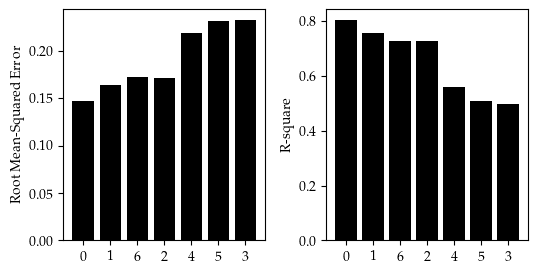

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=100, gridspec_kw={'wspace':.3})
x = filtered.index
axes[0].bar([str(xx) for xx in x], filtered.rmse, color='k')
axes[1].bar([str(xx) for xx in x], filtered.r2, color='k')

axes[0].set_ylabel('Root Mean-Squared Error')
axes[1].set_ylabel('R-square')

# Classification

In [99]:
rows = []
for f in all_folders:
    with open(os.path.join(f, 'pretraining', 'config.toml'), 'r') as handle:
        conf = toml.load(handle)
    for ds in ['alcock', 'atlas']:
        for ns in [20, 100]:
            for fold_n in range(3):
                try:
                    clf_path = os.path.join(f, 'classification', 
                                            ds, 
                                            'fold_{}'.format(fold_n), 
                                            '{}_{}'.format(ds, ns),
                                            'att_mlp',
                                            'metrics.toml') 
                    with open(clf_path, 'r') as handle:
                        metrics = toml.load(handle)
                        for key in metrics.keys():
                            metrics[key] = float(metrics[key])
                        metrics['dataset'] = ds
                        metrics['spc'] = ns
                        metrics['path'] = f.split('results/')[-1]
                        metrics['fold'] = fold_n
                        metrics['clf'] = 'att_mlp'
                        
                        rows.append(metrics)
                except:
                    continue

In [100]:
df = pd.DataFrame(rows)

In [101]:
df_summary = df.groupby(['spc', 'dataset', 'clf', 'path']).mean().reset_index()
df_summary_std = df.groupby(['spc', 'dataset', 'clf', 'path']).std().reset_index()
df_summary

,spc,dataset,clf,path,clf_val_acc,clf_val_loss,clf_test_precision,clf_test_recall,clf_test_f1,clf_test_acc,fold
0,20,alcock,att_mlp,v_first/2023-10-14_16-56-26,0.306725,1.617891,0.245748,0.288208,0.217909,0.326358,1.0
1,20,alcock,att_mlp,vh_first/2023-10-14_16-57-22,0.418458,1.377244,0.330419,0.339849,0.303717,0.361400,1.0
2,20,alcock,att_mlp,vh_first/2023-10-16_13-54-52,0.383443,1.509210,0.297575,0.346889,0.294845,0.371273,1.0
3,20,atlas,att_mlp,v_first/2023-10-14_16-56-26,0.483333,1.108245,0.421132,0.464609,0.432537,0.461005,1.0
4,20,atlas,att_mlp,vh_first/2023-10-16_13-54-52,0.595455,1.008724,0.545043,0.532664,0.518050,0.529233,1.0
5,100,alcock,att_mlp,v_first/2023-10-14_16-56-26,0.282592,1.673160,0.141411,0.219516,0.138238,0.250574,1.0
6,100,alcock,att_mlp,vh_first/2023-10-14_16-57-22,0.529933,1.231816,0.477041,0.437402,0.427914,0.450758,0.0
7,100,alcock,att_mlp,vh_first/2023-10-16_13-54-52,0.515937,1.227706,0.510216,0.481934,0.481491,0.497495,1.0
8,100,atlas,att_mlp,v_first/2023-10-14_16-56-26,0.496829,1.037882,0.512844,0.508329,0.503860,0.503735,1.0
9,100,atlas,att_mlp,vh_first/2023-10-16_13-54-52,0.611917,0.916104,0.589142,0.604098,0.586281,0.602347,1.0


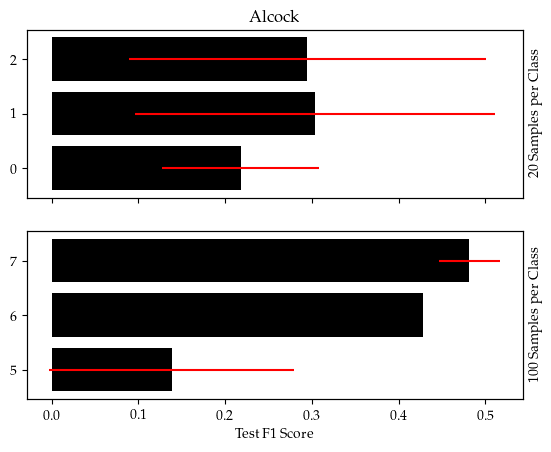

In [102]:
fig, axes = plt.subplots(2, 1, sharex=True, dpi=100)

axes[0].set_title('Alcock')
axes[-1].set_xlabel('Test F1 Score')
for k, spc in enumerate([20, 100]):
    y = df_summary[(df_summary['dataset'] == 'alcock') & (df_summary['spc']==spc)]['clf_test_f1']
    y_err = df_summary_std[(df_summary_std['dataset'] == 'alcock') & (df_summary_std['spc']==spc)]['clf_test_f1']
    x = df_summary[(df_summary['dataset'] == 'alcock') & (df_summary['spc']==spc)].index
    
    axes[k].barh(x, y, xerr=y_err, color='k', error_kw={'ecolor':'red'})
    axes[k].set_yticks(x)
    ax2 = axes[k].twinx()
    ax2.set_yticks([])
    ax2.set_ylabel('{} Samples per Class'.format(spc))

    ax2.yaxis.tick_right()

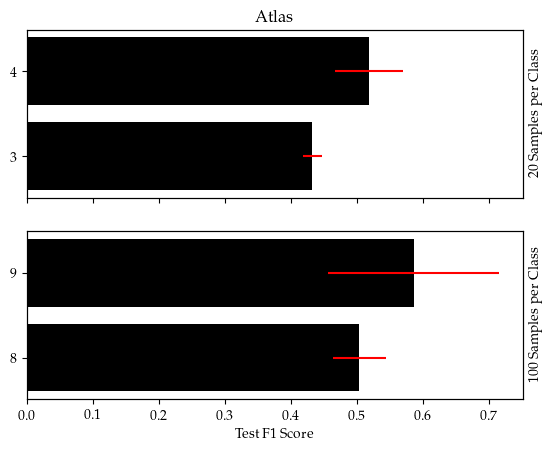

In [103]:
fig, axes = plt.subplots(2, 1, sharex=True, dpi=100)

axes[0].set_title('Atlas')
axes[-1].set_xlabel('Test F1 Score')
for k, spc in enumerate([20, 100]):
    y = df_summary[(df_summary['dataset'] == 'atlas') & (df_summary['spc']==spc)]['clf_test_f1']
    y_err = df_summary_std[(df_summary_std['dataset'] == 'atlas') & (df_summary_std['spc']==spc)]['clf_test_f1']
    x = df_summary[(df_summary['dataset'] == 'atlas') & (df_summary['spc']==spc)].index
    
    axes[k].barh(x, y, xerr=y_err, color='k', error_kw={'ecolor':'red'})
    axes[k].set_yticks(x)
    ax2 = axes[k].twinx()
    ax2.set_yticks([])
    ax2.set_ylabel('{} Samples per Class'.format(spc))

    ax2.yaxis.tick_right()

In [108]:
df_summary

,spc,dataset,clf,path,clf_val_acc,clf_val_loss,clf_test_precision,clf_test_recall,clf_test_f1,clf_test_acc,fold
0,20,alcock,att_mlp,v_first/2023-10-14_16-56-26,0.306725,1.617891,0.245748,0.288208,0.217909,0.326358,1.0
1,20,alcock,att_mlp,vh_first/2023-10-14_16-57-22,0.418458,1.377244,0.330419,0.339849,0.303717,0.361400,1.0
2,20,alcock,att_mlp,vh_first/2023-10-16_13-54-52,0.383443,1.509210,0.297575,0.346889,0.294845,0.371273,1.0
3,20,atlas,att_mlp,v_first/2023-10-14_16-56-26,0.483333,1.108245,0.421132,0.464609,0.432537,0.461005,1.0
4,20,atlas,att_mlp,vh_first/2023-10-16_13-54-52,0.595455,1.008724,0.545043,0.532664,0.518050,0.529233,1.0
5,100,alcock,att_mlp,v_first/2023-10-14_16-56-26,0.282592,1.673160,0.141411,0.219516,0.138238,0.250574,1.0
6,100,alcock,att_mlp,vh_first/2023-10-14_16-57-22,0.529933,1.231816,0.477041,0.437402,0.427914,0.450758,0.0
7,100,alcock,att_mlp,vh_first/2023-10-16_13-54-52,0.515937,1.227706,0.510216,0.481934,0.481491,0.497495,1.0
8,100,atlas,att_mlp,v_first/2023-10-14_16-56-26,0.496829,1.037882,0.512844,0.508329,0.503860,0.503735,1.0
9,100,atlas,att_mlp,vh_first/2023-10-16_13-54-52,0.611917,0.916104,0.589142,0.604098,0.586281,0.602347,1.0


In [109]:
filtered

,exp_name,probed,dropout,r2,rmse,scheduler,state,path
0,bugstromer,0.5,0.0,0.8009453,0.14739424,True,finished,bugstromer/2023-10-16_14-06-03
1,bugstromer_nc,0.5,0.0,0.7551994,0.16355138,True,running,bugstromer_nc/2023-10-16_12-34-51
6,v_first,0.5,0.0,0.7278124,0.17235895,NaN,finished,v_first/2023-10-14_16-56-26
2,vh_first_20,0.2,0.0,0.7260181,0.17171612,True,running,vh_first_20/2023-10-17_12-29-02
4,vh_first,0.5,0.0,0.5601274,0.2189873,NaN,finished,vh_first/2023-10-14_16-57-22
5,vh_first,0.5,0.0,0.50878996,0.23133539,True,finished,vh_first/2023-10-16_13-54-52
3,vh_first_20,0.2,0.1,0.4971161,0.23213328,True,finished,vh_first_20/2023-10-17_19-25-34


In [116]:
result = pd.merge(filtered, df_summary, on="path", how="left")
result


,exp_name,probed,dropout,r2,rmse,scheduler,state,path,spc,dataset,clf,clf_val_acc,clf_val_loss,clf_test_precision,clf_test_recall,clf_test_f1,clf_test_acc,fold
0,bugstromer,0.5,0.0,0.8009453,0.14739424,True,finished,bugstromer/2023-10-16_14-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bugstromer_nc,0.5,0.0,0.7551994,0.16355138,True,running,bugstromer_nc/2023-10-16_12-34-51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,v_first,0.5,0.0,0.7278124,0.17235895,NaN,finished,v_first/2023-10-14_16-56-26,20.0,alcock,att_mlp,0.306725,1.617891,0.245748,0.288208,0.217909,0.326358,1.0
3,v_first,0.5,0.0,0.7278124,0.17235895,NaN,finished,v_first/2023-10-14_16-56-26,20.0,atlas,att_mlp,0.483333,1.108245,0.421132,0.464609,0.432537,0.461005,1.0
4,v_first,0.5,0.0,0.7278124,0.17235895,NaN,finished,v_first/2023-10-14_16-56-26,100.0,alcock,att_mlp,0.282592,1.673160,0.141411,0.219516,0.138238,0.250574,1.0
5,v_first,0.5,0.0,0.7278124,0.17235895,NaN,finished,v_first/2023-10-14_16-56-26,100.0,atlas,att_mlp,0.496829,1.037882,0.512844,0.508329,0.503860,0.503735,1.0
6,vh_first_20,0.2,0.0,0.7260181,0.17171612,True,running,vh_first_20/2023-10-17_12-29-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,vh_first,0.5,0.0,0.5601274,0.2189873,NaN,finished,vh_first/2023-10-14_16-57-22,20.0,alcock,att_mlp,0.418458,1.377244,0.330419,0.339849,0.303717,0.361400,1.0
8,vh_first,0.5,0.0,0.5601274,0.2189873,NaN,finished,vh_first/2023-10-14_16-57-22,100.0,alcock,att_mlp,0.529933,1.231816,0.477041,0.437402,0.427914,0.450758,0.0
9,vh_first,0.5,0.0,0.50878996,0.23133539,True,finished,vh_first/2023-10-16_13-54-52,20.0,alcock,att_mlp,0.383443,1.509210,0.297575,0.346889,0.294845,0.371273,1.0


In [186]:
columns_to_compare = ['clf_test_f1', 'rmse', 'r2', 'spc']
valid = result[columns_to_compare].dropna().astype(float)

valid

,clf_test_f1,rmse,r2,spc
2,0.217909,0.172359,0.727812,20.0
3,0.432537,0.172359,0.727812,20.0
4,0.138238,0.172359,0.727812,100.0
5,0.503860,0.172359,0.727812,100.0
7,0.303717,0.218987,0.560127,20.0
8,0.427914,0.218987,0.560127,100.0
9,0.294845,0.231335,0.508790,20.0
10,0.518050,0.231335,0.508790,20.0
11,0.481491,0.231335,0.508790,100.0
12,0.586281,0.231335,0.508790,100.0


In [187]:
import seaborn as sns

valid.shape

(10, 4)

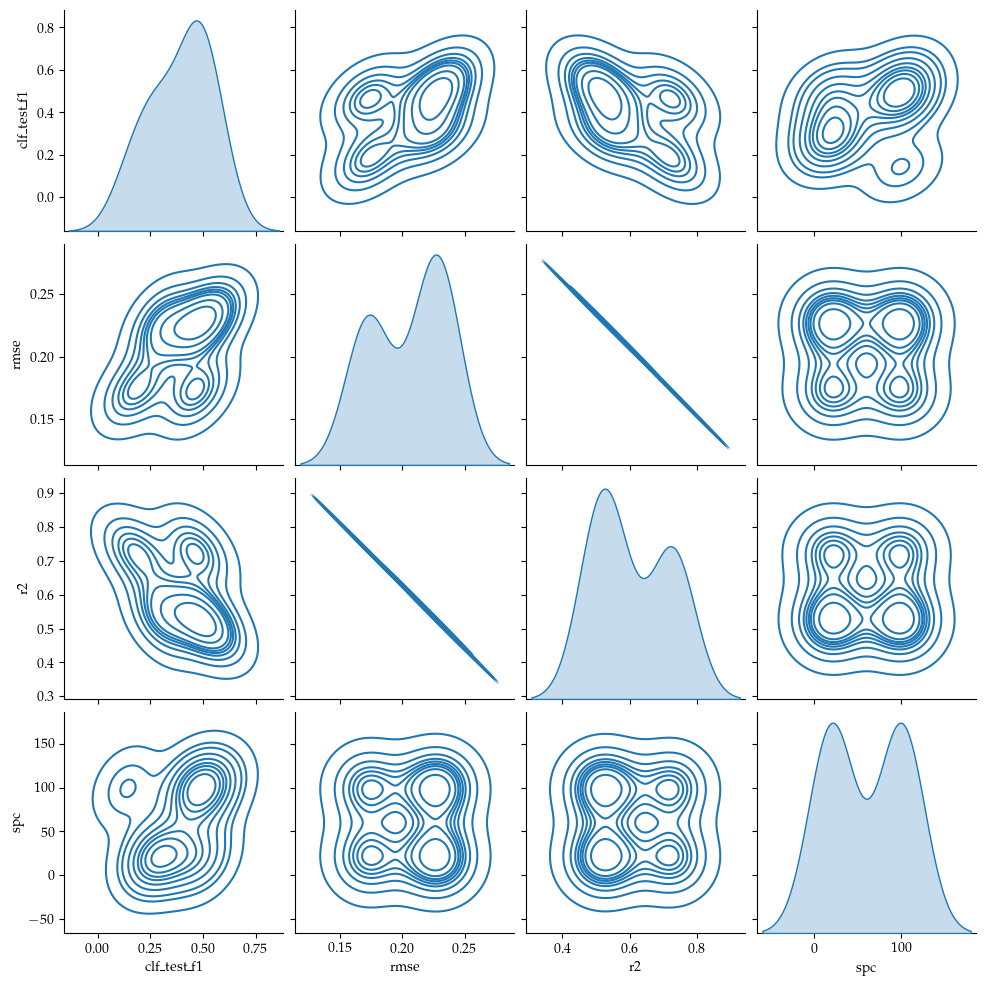

In [189]:
sns.pairplot(valid, vars=columns_to_compare, kind='kde')